In [181]:
import itertools
import os

import numpy as np
import pandas as pd

# column descriptions from https://www.retrosheet.org/gamelogs/glfields.txt
offensive_stats = ['AB', 'H', '2B', '3B', 'HR', 'RBI', 'SAC', 'SAC_FLY', 'HBP', 'BB', 'IBB', 'K', 'SB', 'CS', 'GDP', 'CI', 'LOB']
pitching_stats = ['pitchers_used', 'indv_earned_runs', 'team_earned_runs', 'wild_pitches', 'balks']
defensive_stats = ['putouts', 'assists', 'errors', 'passed_balls', 'double_plays', 'triple_plays']
roles = ['home_plate_ump', '1B_ump', '2B_ump', '3B_ump', 'LF_ump', 'RF_ump', 'away_manager', 'home_manager',
         'winning_pitcher', 'losing_pitcher', 'saving_pitcher', 'winning_rbi_batter', 'away_starting_pitcher', 'home_starting_pitcher']
columns = [
    'date',
    'series_game_num',
    'dow',
    'away_team',
    'away_team_league',
    'away_team_game_num',
    'home_team',
    'home_team_league',
    'home_team_game_num',
    'score_away',
    'score_home',
    'count_outs',
    'day_or_night',
    'makeup_info',
    'forfeit_info',
    'protest_info',
    'park_id',
    'attendance',
    'length_minutes',
    'away_line_score',
    'home_line_score',
    *['away_' + offensive_stat for offensive_stat in offensive_stats],
    *['away_' + pitching_stat for pitching_stat in pitching_stats],
    *['away_' + defensive_stat for defensive_stat in defensive_stats],
    *['home_' + offensive_stat for offensive_stat in offensive_stats],
    *['home_' + pitching_stat for pitching_stat in pitching_stats],
    *['home_' + defensive_stat for defensive_stat in defensive_stats],
    *list(itertools.chain.from_iterable([[role + '_id', role + '_name'] for role in roles])),
    *list(itertools.chain.from_iterable([[f'away_lineup{i}_id', f'away_lineup{i}_name', f'away_lineup{i}_pos'] for i in range(1, 10)])),
    *list(itertools.chain.from_iterable([[f'home_lineup{i}_id', f'home_lineup{i}_name', f'home_lineup{i}_pos'] for i in range(1, 10)])),
    'misc',
    'acquisition_info'
]

def file_to_df(fn):
    df = pd.read_csv(fn, header=None, names=columns)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df['year'] = df['date'].dt.year
    df['home_won'] = df['score_home'] > df['score_away']
    return df

def opposite_side(side):
    return 'home' if side == 'away' else 'away'

dfs = []
for fn in os.listdir('data'):
    year_df = file_to_df(f'data/{fn}')
    dfs.append(year_df)
    
df = pd.concat(dfs).sort_values(['date', 'home_team_game_num'])

In [268]:
def build_features(year_to_test):
    one_year = df.loc[df['year'] == year_to_test]

    side_games_dfs = []
    for side in ['home', 'away']:
        side_games = one_year.copy()
        side_games['won'] = one_year['home_won'] if side == 'home' else ~one_year['home_won']
        side_games['team'] = one_year[f'{side}_team']
        side_games['game_num'] = one_year[f'{side}_team_game_num'] + 1 # win pct = pct before game_num, to avoid lookahead bias
        side_games['score_for'] = one_year[f'score_{side}']
        side_games['score_against'] = one_year[f'score_{opposite_side(side)}']
        side_games_dfs.append(side_games)

    team_games = pd.concat(side_games_dfs).sort_values(['team', 'game_num'])

    tmp = team_games.pivot(columns='team', values='won', index='game_num').cumsum()
    team_wins = tmp.divide(tmp.index.values, axis='rows').unstack().rename('win_pct')

    team_runs_for = team_games.pivot(columns='team', values='score_for', index='game_num').cumsum().unstack()
    team_avg_score_for = (team_runs_for / team_runs_for.index.get_level_values(1) - 1).rename('avg_score_for')

    team_runs_against = team_games.pivot(columns='team', values='score_against', index='game_num').cumsum().unstack()
    team_avg_score_against = (team_runs_against / team_runs_against.index.get_level_values(1) - 1).rename('avg_score_against')

    team_era = (team_runs_against / (team_runs_against.index.get_level_values(1) - 1)).rename('era')

    team_pythag = ((team_avg_score_for * (team_avg_score_for.index.get_level_values(1) - 1))**1.83 / (
        (team_avg_score_for * (team_avg_score_for.index.get_level_values(1) - 1))**1.83
        + (team_avg_score_against * (team_avg_score_against.index.get_level_values(1) - 1))**1.83
    )).rename('pythag')
    team_stats = pd.concat([
        team_wins, team_avg_score_for, team_avg_score_against, team_pythag, team_era
    ], axis='columns').reset_index()

    tmp = pd.merge(
        one_year[['date', 'home_team', 'away_team', 'home_team_game_num', 'away_team_game_num', 'home_won']],
        team_stats.rename(columns={col: 'home_team' if col == 'team' else f'home_team_{col}' for col in team_stats.columns}),
        on=['home_team', 'home_team_game_num']
    )
    games = pd.merge(
        tmp,
        team_stats.rename(columns={col: 'away_team' if col == 'team' else f'away_team_{col}' for col in team_stats.columns}),
        on=['away_team', 'away_team_game_num']
    ).sort_values(['date', 'home_team_game_num'])

    games['log5'] = ((games['home_team_win_pct'] - (games['home_team_win_pct'] * games['away_team_win_pct'])) / (
        games['home_team_win_pct'] + games['away_team_win_pct'] - (2 * games['home_team_win_pct'] * games['away_team_win_pct'])
    ).replace(0, 1)).astype(float)
    games['pythag'] = games['home_team_pythag'] - games['away_team_pythag']

#     games['pred_score_home'] = np.sqrt(games['home_team_avg_score_for'] * games['away_team_avg_score_against'])
#     games['pred_score_away'] = np.sqrt(games['away_team_avg_score_for'] * games['home_team_avg_score_against'])
#     games['pred_score_diff'] = games['pred_score_home'] - games['pred_score_away']
    games['era_diff'] = games['home_team_era'] - games['away_team_era']   
    return games[games['home_team_game_num'] > 10]

In [273]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

games = pd.concat([build_features(year) for year in range(2000, 2020)], ignore_index=True)
features = ['log5', 'pythag', 'era_diff']
train_size = 5000

model = LogisticRegression()
model.fit(games.loc[:train_size, features], games.loc[:train_size, 'home_won'])

train = games.loc[train_size + 1 : games.shape[0] + 1]
train['pred'] = model.predict(train.loc[:,features])
(train['pred'] == train['home_won']).sum() / train.shape[0] 

/home/mpark/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_116/3459252499.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred'] = model.predict(train.loc[:,features])


0.5588511749347258

In [278]:
df['home_H']

0      13
1       6
2       7
3      13
4       7
       ..
893     6
894    10
895     9
896    11
897     7
Name: home_H, Length: 47057, dtype: int64

In [274]:
games[features + ['home_won']].corr()

,log5,pythag,era_diff,home_won
log5,1.000000,0.876045,-0.674564,0.112530
pythag,0.876045,1.000000,-0.738762,0.120075
era_diff,-0.674564,-0.738762,1.000000,-0.100312
home_won,0.112530,0.120075,-0.100312,1.000000


<AxesSubplot:title={'center':'Cumulative accuracy of different models after April, when they are more stable'}, xlabel='date'>

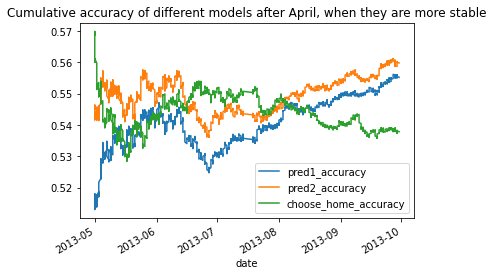

In [355]:
games['pred_score_home'] = np.sqrt(games['home_team_avg_score_for'] * games['away_team_avg_score_against'])
games['pred_score_away'] = np.sqrt(games['away_team_avg_score_for'] * games['home_team_avg_score_against'])
games['pred_score_diff'] = games['pred_score_home'] - games['pred_score_away']
games['pred_score_diff_std'] = np.sqrt(games['home_team_avg_score_for'].var() + games['away_team_avg_score_for'].var())
games['home_win_prob1'] = (games['pred_score_diff'] / games['pred_score_diff_std']).apply(norm.cdf)
games['home_win_prob2'] = df.loc[df['year'] == 2010, 'home_won'].value_counts(normalize=True)[True]
games['pred1_correct'] = (games['home_win_prob1'] > .5) == games['home_won']
games['pred2_correct'] = ((games['home_win_prob1'] + games['home_win_prob2']) / 2 > .5) == games['home_won']

games[['pred1_accuracy', 'pred2_accuracy', 'choose_home_accuracy']] = games[['pred1_correct', 'pred2_correct', 'home_won']].reset_index(drop=True).cumsum().divide(games.index.values, axis='rows')
games.loc[:, ['date', 'pred1_accuracy', 'pred2_accuracy', 'choose_home_accuracy']].plot(x='date', title='Cumulative accuracy of different models')